# kaggle 신용카드 사기 검출 - 오버샘플링, 언더샘플링

In [2]:
# 케글 신용카드 사기 검출 데이터 세트

### kaggle 신용카드 사기 검출 데이터세트

* 데이터셋 위치
https://www.kaggle.com/mlg-ulb/creditcardfraud

- 사기(Fraud) 트랜잭션: 1 (전체의 0.172%) 
- 정상 신용카드 트랜잭션: 0
성능평가: ROC-AUC ( 대부분이 정상 거래이고 사기거래 데이터는 소수인 극도로 불균형 데이터세트)

- 데이터셋 다운로드: 
https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv

- 다운로드 후 데이터셋 압축풀기
creditcard.zip -> creditcard.csv


- LogisticRegression, LightGBM으로 예측

## 분석 순서

1. 로지스틱 분류
2. LightGBM 분류
3. 데이터 분포 왜곡 개선 후 모델 각각 재적용 <br>
    1) 정규 분포 형태로 변경 후 모델 각각 재적용<br>
    2) 로그 변환 후 모델 각각 재적용<br>
4. 이상치 데이터 제거 후 모델 각각 재적용
5. SMOTE 오버 샘플링후 모델 각각 재적용

In [5]:
#!pip install imbalanced-learn


In [6]:
# conda install -c conda-forge imbalanced-learn

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
from sklearn.model_selection import train_test_split

df_copy = card_df.copy()
df_copy.drop('Time', axis=1, inplace=True)

X = df_copy.iloc[:, :-1]
y= df_copy.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [6]:
# 클래스 비율 확인
print(y_train.value_counts(normalize=True))
print('-'*10)
print(y_test.value_counts(normalize=True))

0    0.998275
1    0.001725
Name: Class, dtype: float64
----------
0    0.998268
1    0.001732
Name: Class, dtype: float64


In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 데이터 일차 가공 및 모델 학습/예측/평가

# 1. LogisticRegression 모델을 활용한 분류

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_clf.fit(X_train, y_train)

get_clf_eval(y_test, lr_clf.predict(X_test),\
    lr_clf.predict_proba(X_test)[:, 1])

오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9704


# 2. LightGBM 모델 학습 및 평가

In [10]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,\
    boost_from_average=False)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(boost_from_average=False, n_estimators=1000, num_leaves=64)

In [14]:
get_clf_eval(y_test, lgbm_clf.predict(X_test), lgbm_clf.predict_proba(X_test)[:, 1])

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


# 3.  데이터 분포도 변환 후 모델 재학습/예측/평가


*  왜곡된 분포도를 가지는 데이터를 재가공한뒤 모델 재테스트

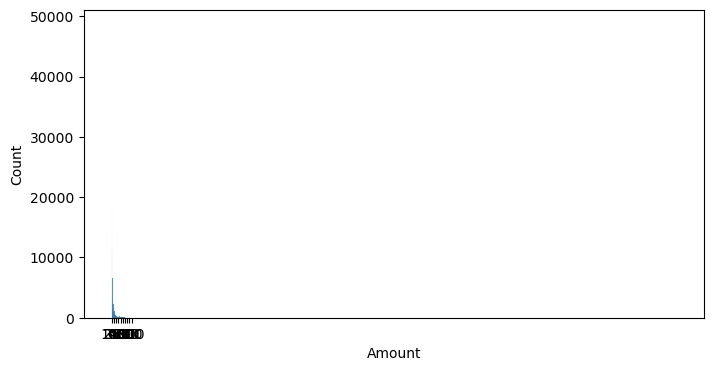

In [16]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 1000, 100))
sns.histplot(card_df.Amount); # 데이터가 skewed 한 걸 확인 가능

(0.0, 25691.16)

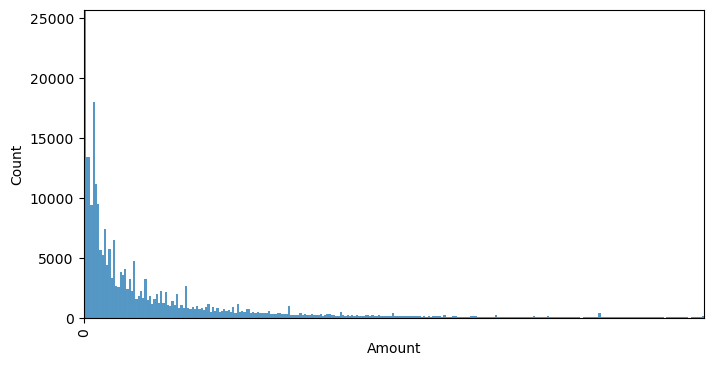

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=90)
sns.histplot(card_df.Amount); # 데이터가 skewed 한 걸 확인 가능
plt.xlim(0, 600)
plt.ylim(0, max(card_df.Amount))

In [21]:
card_df.Amount.value_counts().sort_index()

0.00        1825
0.01         718
0.02          85
0.03           3
0.04          11
            ... 
11898.09       1
12910.93       1
18910.00       1
19656.53       1
25691.16       1
Name: Amount, Length: 32767, dtype: int64

* 1. 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 

In [25]:
from sklearn.preprocessing import StandardScaler

df_copy = card_df.copy()
scaler = StandardScaler()

new_amount = scaler.fit_transform(df_copy.Amount.values.reshape(-1, 1))
df_copy.drop(['Time'], axis=1, inplace=True)
df_copy['Amount'] = new_amount

X= df_copy.iloc[:, :-1]
y= df_copy.iloc[:, -1]

X.shape, y.shape

((284807, 29), (284807,))

In [28]:
# 학습 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [29]:
from sklearn.linear_model import LogisticRegression
# logistic 회귀 
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_clf.fit(X_train, y_train)

print(get_clf_eval(y_test, lr_clf.predict(X_test),
            lr_clf.predict_proba(X_test)[:, 1] ))

#lgbm 결과
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                        boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
print(get_clf_eval(y_test, lgbm_clf.predict(X_test),
            lgbm_clf.predict_proba(X_test)[:, 1]))

오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
None
오차 행렬
[[85291     4]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9655, 재현율: 0.7568,    F1: 0.8485, AUC:0.9782
None


2. numpy log1p를 사용하여 Amount 피처값을 로그 변환하는 로직으로 수정.
- 로그변환: 데이터 분포도가 심하게 왜곡되어 있을 경우 적용. 
- 원래 값을 log 값으로 변환해 상대적으로 작은 값으로 변경, 데이터 분포의 왜곡을 개선

In [31]:
# Amount를  로그 변환하는 로직으로 수정
df_copy = card_df.copy()

amount_n = np.log1p(df_copy['Amount'])
# 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
df_copy.drop(['Time'], axis=1, inplace=True)
df_copy['Amount'] = amount_n

X = df_copy.iloc[:, :-1]
y = df_copy.iloc[:, -1]

# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [32]:
from sklearn.linear_model import LogisticRegression
# logistic 회귀 
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_clf.fit(X_train, y_train)

print(get_clf_eval(y_test, lr_clf.predict(X_test),
             lr_clf.predict_proba(X_test)[:, 1] ))

#lgbm 결과
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
print(get_clf_eval(y_test, lgbm_clf.predict(X_test),
             lgbm_clf.predict_proba(X_test)[:, 1]))

오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
None
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790
None


------------------------------------------------------------------------------------------------------

# 4. 이상치(Outlier) 데이터 제거 후 모델 학습/예측/평가

In [35]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    #print(fraud.index)
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [ ]:
get_outlier(card_df, '')

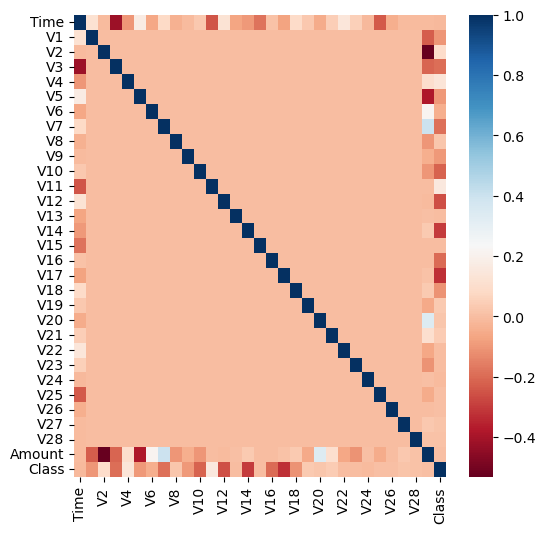

In [33]:
# 이상치를 제거하기 전에 어떤 칼럼(특성)의 이상치를 제거할 것인지 해당 컬럼(특성)을 확정해야 한다
# 이를 위해 클래스(레이블)과 상관관계가 높은 컬럼을 확인한다

import seaborn as sns
plt.figure(figsize=(6, 6))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu');

In [37]:
# 상관관계가 높은 것으로 판명된 v14, v17 중 v14의 이상치를 제거한다
get_outlier(card_df, 'V14', weight=1.5)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

In [38]:
# 확인한 이상치 인덱스의 레코드를 전체 데이터셋에서 제거함
# Amount를  로그 변환하는 로직으로 수정
df_copy = card_df.copy()

amount_n = np.log1p(df_copy['Amount'])
# 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
df_copy.drop(['Time'], axis=1, inplace=True)
df_copy['Amount'] = amount_n

# 이상치 데이터 삭제
outlier_index = get_outlier(df_copy, 'V14')
df_copy.drop(outlier_index, axis=0, inplace=True)

# 데이터 준비
X = df_copy.iloc[:, :-1]
y = df_copy.iloc[:, -1]

# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [39]:
from sklearn.linear_model import LogisticRegression
# logistic 회귀 
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_clf.fit(X_train, y_train)

print(get_clf_eval(y_test, lr_clf.predict(X_test),
             lr_clf.predict_proba(X_test)[:, 1] ))

#lgbm 결과
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
print(get_clf_eval(y_test, lgbm_clf.predict(X_test),
             lgbm_clf.predict_proba(X_test)[:, 1]))

오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
None
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288,    F1: 0.8930, AUC:0.9791
None


# 5. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

심한 inbalance 가 일어났을 때 사용한다.

In [43]:
from imblearn.over_sampling import SMOTE

In [44]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [45]:
y_train.value_counts(normalize=True)

0    0.998285
1    0.001715
Name: Class, dtype: float64

In [46]:
y_train_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: Class, dtype: float64

In [48]:
from sklearn.linear_model import LogisticRegression
# logistic 회귀 
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_clf.fit(X_train_over, y_train_over)

print(get_clf_eval(y_test, lr_clf.predict(X_test),
            lr_clf.predict_proba(X_test)[:, 1] ))

#lgbm 결과
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                        boost_from_average=False)
lgbm_clf.fit(X_train_over, y_train_over)
print(get_clf_eval(y_test, lgbm_clf.predict(X_test),
            lgbm_clf.predict_proba(X_test)[:, 1]))

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737
None
오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814
None


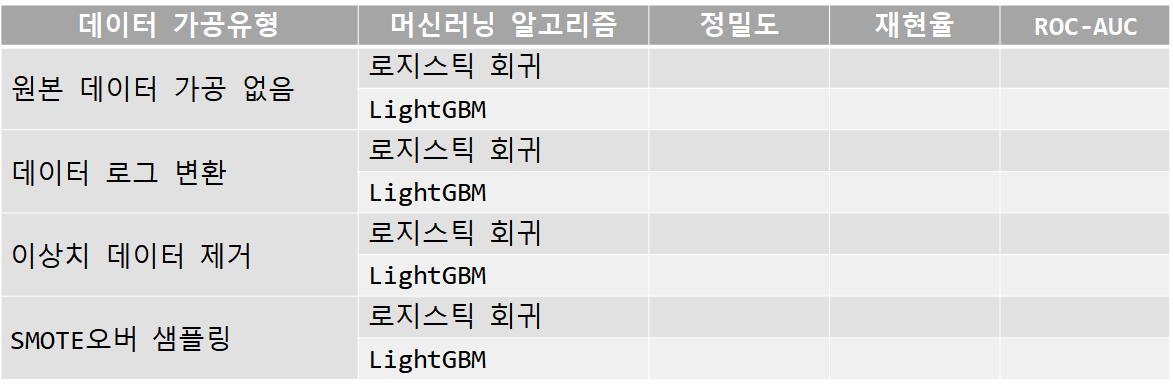